<a href="https://colab.research.google.com/github/KseniiaKolesnichenko/MISIS-recomendation-systems-/blob/main/Future_pred_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade numpy

     |████████████████████████████████| 15.7 MB 189 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import RNN, LSTM
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import sys
import copy
%matplotlib inline

In [ ]:
np.__version__

'1.21.2'

In [ ]:
!nvidia-smi

Mon Sep 13 14:11:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Загрузка и предобработка данных

In [ ]:
%%time
#Читаем данные
df_list=[]
directory='drive/MyDrive/Colab Notebooks/Drilling_error_prediction/'
files=glob.glob(directory+"Data/* глубин*.csv")
print(f'Reading from files:{files}')
print(f'{len(files)} total')
for file in files:
    df_list.append(pd.read_csv(file, index_col=0))

NameError: ignored

In [ ]:
#Масштабы
scales=pd.read_excel(directory+'Масштабы.xlsx')
#Коды литологии и стратиграфии
litology_code=pd.read_csv(directory+'Литология_коды.csv', header=1, delimiter=';', usecols=[0,1])
stratigraphy_code=pd.read_csv(directory+'Стратиграфия_коды.csv', header=1, delimiter=';', usecols=[0,1])

In [ ]:
#Преобразуем типы и вставляем 0 в колонку Код осложнений
for ind in range(len(df_list)):
    df_list[ind]['Код осложнений'].fillna(value=0, inplace=True)
    df_list[ind]=df_list[ind].astype(np.float32, copy=False) 
    df_list[ind]=df_list[ind].astype({'Код Литологии': np.uint16,'Код осложнений': np.uint16, 
                                      'Код стратиграфии': np.uint16}, copy=False) 

In [ ]:
#Заменяем значение -999.25 на NaN
for df in df_list:
    df.replace(-999.25, np.nan, inplace=True)

In [ ]:
#Выбрасываем колонки, в которых часто встречаются пустые значения
for df in df_list:
    df.drop(columns='Код горизонта маркера', inplace=True)
    df.drop(columns='БПР 1', inplace=True)
    df.drop(columns='ЦСГО 2', inplace=True)
    df.drop(columns='Расход на вых.', inplace=True)
    df.drop(columns=['С1', 'С2', 'С3', 'С4', 'C5', 'iС4', 'IC5'], inplace=True)
    if 'БПР 2' in df:
        df.drop(columns='БПР 2', inplace=True)
    if 'Долив 2' in df:
        df.drop(columns='Долив 2', inplace=True)

In [ ]:
for df, file in zip(df_list, files):
    rows_with_NA=df.isna().any(axis=1).sum()
    print(f'In file {file} number of NaN values: {rows_with_NA},\
part of NaN values: {rows_with_NA/len(df)*100:.2f} %\n')

In [ ]:
#Выбрасываем строки с отсутствующими значениями
for df in df_list:
    df.dropna(inplace=True)

In [ ]:
#Зануляем все что меньше 0
for ind in range(len(df_list)):
    df_list[ind][(df_list[ind]<0)]=0

In [ ]:
#Мин мах нормализация данных в соответствии с масштабом из файла "Масштабы.xlsx"
for df in df_list:
    for column in df.columns:
        if not scales[column].isnull().all():
            max_value = scales[column].loc[2]
            min_value = scales[column].loc[1]
            df[column] = (df[column] - min_value) / (max_value - min_value)

In [ ]:
min_depth=scales['Глубина'].loc[1]
max_depth=scales['Глубина'].loc[2]

In [ ]:
df_list[0].head()

# Сортировка параметров по корреляции

In [ ]:
correlation=[]
for df in df_list:
    correlation.append(df.corr())
total_df=pd.concat(df_list)

In [ ]:
sorted_parameters=total_df.corr()['Код осложнений'].abs().sort_values()
#.drop(index=[],inplace=True)

In [ ]:
sorted_parameters.drop(index=['Глубина', 'Код стратиграфии', 'Код Литологии','Код осложнений'],
                      inplace=True)
sorted_parameters=sorted_parameters.index[::-1]

In [ ]:
sorted_parameters

Index(['Положение долота', 'Диаметр долота', 'Диаметр скважины', 'ЦСГО 1',
       'Долив', 'Обороты рот', 'Сумма актив. емкостей', 'Мех. скорость ср',
       'Рабочая емк. 1', 'Температура вх', 'Рабочая емк. 2', 'Вес на кр',
       'Давление', 'Положение кр', 'Плотность на вх', 'Плотность на вых',
       'Нагр. На долото', 'Температура вых', 'Расход на вх'],
      dtype='object')

# Формирование датасета из данных

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import random

In [ ]:
def random_sampling(X_list, Y_list, n_test):
  random.seed(777)
  test_ind=random.sample(range(len(X_list)), n_test)
  length_of_train_dataset=0
  length_of_test_dataset=0
  for ind, Y in enumerate(Y_list):
    if ind in test_ind:
      length_of_test_dataset+=len(Y)
    else:
      length_of_train_dataset+=len(Y)
  X_dataset_shape=X_list[0].shape[1:]
  train_X_dataset_shape=tuple([length_of_train_dataset])+X_dataset_shape
  test_X_dataset_shape=tuple([length_of_test_dataset])+X_dataset_shape

  Y_dataset_shape=Y_list[0].shape[1:]
  train_Y_dataset_shape=tuple([length_of_train_dataset])+Y_dataset_shape
  test_Y_dataset_shape=tuple([length_of_test_dataset])+Y_dataset_shape

  X_train=np.zeros(train_X_dataset_shape, dtype=np.float16)
  X_test=np.zeros(test_X_dataset_shape, dtype=np.float16)
  Y_train=np.zeros(train_Y_dataset_shape, dtype=np.float16)
  Y_test=np.zeros(test_Y_dataset_shape, dtype=np.float16)

  print(f'Indices for test dataset: {test_ind}')
  current_train_ind=0
  current_test_ind=0
  for ind, (X, Y) in enumerate(zip(X_list, Y_list)):

    if ind in test_ind:
      X_test[current_test_ind:current_test_ind+len(X)]=X
      Y_test[current_test_ind:current_test_ind+len(Y)]=Y
      current_test_ind+=len(Y)

    else:
      X_train[current_train_ind:current_train_ind+len(X)]=X
      Y_train[current_train_ind:current_train_ind+len(Y)]=Y
      current_train_ind+=len(Y)
  return X_train, Y_train, X_test, Y_test, test_ind

In [ ]:
#В файлах встречаются коды литологии 12, 16, 113
#Встречаются стратиграфии 30
lit_codes=np.sort(np.hstack([litology_code['Код литологии'].values,12,16,113, 64537]))
print(f"Количество литологий: {len(lit_codes)}")
strat_codes=np.sort(np.hstack([stratigraphy_code['Код стратиграфии'].values])).reshape(1,-1)
print(f"Количество стратиграфий: {len(strat_codes[0])}")

Количество литологий: 20
Количество стратиграфий: 22


In [ ]:
encoder_lit = OneHotEncoder(categories=lit_codes.reshape(1,-1))
encoder_strat = OneHotEncoder(categories=strat_codes)
label_encoder=LabelEncoder()

In [ ]:
number_of_sorted_parameters=-1
columns_to_use=['Глубина']+sorted_parameters[:number_of_sorted_parameters].values.tolist()
print(columns_to_use)
print(f"Количество используемых параметров {len(columns_to_use)}")

['Глубина', 'Положение долота', 'Диаметр долота', 'Диаметр скважины', 'ЦСГО 1', 'Долив', 'Обороты рот', 'Сумма актив. емкостей', 'Мех. скорость ср', 'Рабочая емк. 1', 'Температура вх', 'Рабочая емк. 2', 'Вес на кр', 'Давление', 'Положение кр', 'Плотность на вх', 'Плотность на вых', 'Нагр. На долото', 'Температура вых']
Количество используемых параметров 19


In [ ]:
#Если нужно, то заменяем некоторые коды литологии и стратиграфии
for df in df_list:
  df.replace({"Код стратиграфии": {30: 31}}, inplace=True)

In [ ]:
%%capture --no-stdout
#Перевод всех данных в двумерный массив и one-hot encoding для столбцов 
#кодов литологии и кодов стратиграфии
total_X=[]
total_Y=[]

for ind,df in enumerate(df_list):
    if len(df)>0:
        print(ind)
        #X=df.drop(columns=['Код Литологии', 'Код осложнений', 'Код стратиграфии']).values
        X=df[columns_to_use].values
        #Y=df['Код осложнений'].values
        Y=(df['Код осложнений'].values>0).astype(int)
        encoded_X_lit=encoder_lit.fit_transform(df['Код Литологии'].values.reshape(-1,1)).toarray()
        encoded_X_strat=encoder_strat.fit_transform(df['Код стратиграфии'].values.reshape(-1,1)).toarray()
        #total_X.append(np.hstack([X, encoded_X_lit, encoded_X_strat]))
        total_X.append(np.hstack([X, encoded_X_strat]))
        total_Y.append(label_encoder.fit_transform(Y))
    else:
        print('0 samples in '+str(ind)+' well')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
print(f'Total amount of wells: {len(total_X)}')

Total amount of wells: 31


In [ ]:
label_encoder.classes_

array([0, 1])

# Объединение данных по глубине

In [ ]:
%%capture --no-stdout
#Объединение данных в группы по number_of_depth_points точек
number_of_depth_points=50
n_steps_forward=10
total_X_grouped=[]
total_Y_grouped=[]
for X in total_X:
    
    grouped_X=np.lib.stride_tricks.sliding_window_view(X,(number_of_depth_points,X.shape[1]))[:-n_steps_forward,0]
    total_X_grouped.append(grouped_X)
for Y in total_Y:
    grouped_Y=np.lib.stride_tricks.sliding_window_view(Y[number_of_depth_points:],(n_steps_forward,))
    total_Y_grouped.append(grouped_Y)
    

In [ ]:
n_samples_in_test_dataset=3
X_train, Y_train , X_test, Y_test, random_samples_ind= random_sampling(total_X_grouped, 
                                                total_Y_grouped, n_samples_in_test_dataset)
print(X_train.shape)
print(X_test.shape)

Indices for test dataset: [7, 14, 11]
(871641, 50, 41)
(99880, 50, 41)


In [ ]:
print(Y_train.shape)
print(Y_test.shape)

(871641, 10)
(99880, 10)


In [ ]:
def Downsampling(X, Y, error_ratio= 0.1):
  ind_of_0=np.argwhere(np.sum(Y, axis=1)==0).flatten().tolist()
  
  ind_of_1=np.argwhere(np.sum(Y, axis=1)>0).flatten().tolist()
  
  n_samples= min(int(len(ind_of_1)*(1/error_ratio-1)), len(ind_of_0))
  
  random.seed(777)
  zero_ind=random.sample(ind_of_0, n_samples)
  
  random.seed(777)
  downsampling_idx = ind_of_1+zero_ind
  random.shuffle(downsampling_idx)
  
  return X[downsampling_idx], Y[downsampling_idx]

In [ ]:
%%time
X_train,Y_train = Downsampling(X_train, Y_train,  error_ratio= 0.1)

CPU times: user 2.43 s, sys: 712 ms, total: 3.14 s
Wall time: 3.14 s


In [ ]:
print(X_train.shape)
print(Y_train.shape)

(666350, 50, 41)
(666350, 10)


# Настройка RNN

In [ ]:
#рекурентная сеть
class GRU_encoder(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, num_layers=1):
        super().__init__()

        self.rnn = nn.GRU(input_size, hidden_size = hidden_dim, num_layers = num_layers, batch_first=True)
        #self.fc = nn.Linear(hidden_dim, output_size)
        self.out_size=output_size
    
    def forward(self, x):
        batch_size = x.size(0)
        #print(x.size())
        #Инициализация скрытого состояния
        hidden_0 = torch.zeros((self.rnn.num_layers, batch_size, self.rnn.hidden_size), device=device) 
        #cell_0 = torch.zeros((self.lstm.num_layers, batch_size, self.lstm.hidden_size), device=device)
        #print(hidden_0.size())
        # Слой LSTM
        
        rnn_out, hidden = self.rnn(x, hidden_0)
         
        #print(hidden.size())
        #Полносвязный слой
        #out = out.contiguous().view(-1, self.rnn.hidden_size)
        #out = hidden[0][-1]
        #out = F.relu(self.fc_intermediate(out))
        #out = self.fc(out)
        return rnn_out, hidden
        #return out.view(-1, self.out_size), out

class GRU_decoder(nn.Module):
    def __init__(self, input_size, hidden_dim, n_classes, n_steps_forward):
      super().__init__()

      self.rnn_cell = nn.GRUCell(input_size, hidden_size = hidden_dim)
      self.fc= nn.Linear(hidden_dim, n_classes)
      self.n_steps=n_steps_forward

    def forward(self,x, encoder_hidden_state):

      current_hidden_state=encoder_hidden_state
      #print(encoder_hidden_state.shape)
      hiddens=[]
      outs=[]
      for _ in range(self.n_steps):
        hidden = self.rnn_cell(x, current_hidden_state)
        hiddens.append(hidden)
        out=self.fc(hidden)
        outs.append(out)
      return outs, hiddens 

class GRU_seq2seq(nn.Module):
    def __init__(self, encoder, decoder, output_size):
      super().__init__()

      self.encoder=encoder
      self.decoder=decoder
      self.out_size=output_size

    def forward(self,x):
      _,encoder_hidden=self.encoder.forward(x)
      
      #print(encoder_hidden.shape)
      outputs,_=self.decoder.forward(x[:,-1],encoder_hidden[0])
      return outputs

In [ ]:
def train(model, loss_function, optimizer , epochs =10, device='cpu'):
    train_loss_hist = []
    test_loss_hist=[]
    train_acc_hist=[]
    test_acc_hist=[]
    best_acc=0
    for epoch in range(epochs):
        ep_loss = 0
        for batch, labels in trainloader: # get bacth 
            batch=batch.to(device)
            labels=labels.to(device)        
            optimizer.zero_grad()
            
            outputs = model(batch) # call forward
            
            loss=0
            for ind, output in enumerate(outputs):
                loss+=(ind+1)/5*loss_function(output, labels[:,ind].long())
            #loss = loss_function(outputs, labels.long()) # calculate loss
            loss.backward() # calculate gradients
            optimizer.step() # performs a single optimization step (parameter update).
            ep_loss += loss.item()
            
        train_loss_hist.append(ep_loss /len(trainloader))
        train_errors_acc,train_acc= validate(model, trainloader, device)
        train_acc_hist.append(train_errors_acc)

        test_errors_acc,test_acc= validate(model, testloader,device)
        test_acc_hist.append(test_errors_acc)
        ep_loss = 0
        with torch.no_grad(): 
            for batch, labels in testloader:
                batch=batch.to(device)
                labels=labels.to(device)
                outputs = model(batch)
                loss=0
                for ind, output in enumerate(outputs):
                  loss+=loss_function(output, labels[:,ind].long())  
                #loss = loss_function(outputs, labels.long())
                ep_loss += loss.item()
        test_loss_hist.append(ep_loss /len(testloader))

        if (test_acc[0]+test_errors_acc[0]>best_acc):
            best_acc=test_acc[0]+test_errors_acc[0]
            best_model= copy.deepcopy(model)
        print(f"Epoch={epoch} train loss={train_loss_hist[epoch]:.4}, \
test loss={test_loss_hist[epoch]:.4}, train accuracy={train_acc[0]:.4f},{train_acc.mean():.4f} \
train error accuracy={train_errors_acc[0]:.4f}, test accuracy={test_acc[0]:.4f},{test_acc.mean():.4f} \
test error accuracy={test_errors_acc[0]:.4f}" )
        
    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model

def validate(model,testloader, device):
    n_outputs = model.decoder.n_steps
    correct_answers = np.zeros(n_outputs)
    correctly_predicted_errors = np.zeros(n_outputs)
    total_samples=np.zeros(n_outputs)
    total_errors=np.zeros(n_outputs)
    
    with torch.no_grad():
        for batch, labels in testloader:
            batch = batch.to(device)
            labels = labels.to(device)
            outputs = model(batch)
            for ind, output in enumerate(outputs):
              label=labels[:,ind]
              _, predicted = torch.max(output.data, 1)
              #print(labels>0)
              correct_answers[ind]=correct_answers[ind]+(predicted == label).sum().item()
              correctly_predicted_errors[ind]=correctly_predicted_errors[ind]+((predicted == label) & (label>0)).sum().item()
              total_samples[ind]=total_samples[ind]+len(label)
              total_errors[ind]=total_errors[ind] + len(label[label>0])
    return correctly_predicted_errors/total_errors, correct_answers/total_samples

# Тренировка сети

In [ ]:
X_train=torch.Tensor(X_train)
Y_train=torch.Tensor(Y_train)

X_test=torch.Tensor(X_test)
Y_test=torch.Tensor(Y_test)

train_dataset=TensorDataset(X_train,Y_train)
test_dataset=TensorDataset(X_test,Y_test)

In [ ]:
#batch_size=8192
batch_size=16384

trainloader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
input_size= X_train.shape[-1]
hidden_size=10
output_size=len(label_encoder.classes_)

In [ ]:
encoder=GRU_encoder(input_size, hidden_size, output_size)
decoder=GRU_decoder(input_size, hidden_size, output_size, n_steps_forward)
model=GRU_seq2seq(encoder,decoder, output_size)
model
model.to(device)

GRU_seq2seq(
  (encoder): GRU_encoder(
    (rnn): GRU(41, 10, batch_first=True)
  )
  (decoder): GRU_decoder(
    (rnn_cell): GRUCell(41, 10)
    (fc): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [ ]:
_,counts=np.unique(Y_train[:,0], return_counts=True)
weights=counts.min()/counts
counts

array([601882,  64468])

In [ ]:
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor(weights).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-1)
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = train(
    model, loss_function, optimizer, epochs = 25, device=device)

Epoch=0 train loss=3.731, test loss=6.273, train accuracy=0.6699,0.6699 train error accuracy=0.6020, test accuracy=0.7138,0.7138 test error accuracy=0.7738
Epoch=1 train loss=3.527, test loss=5.901, train accuracy=0.6910,0.6910 train error accuracy=0.5947, test accuracy=0.7204,0.7204 test error accuracy=0.7738
Epoch=2 train loss=3.444, test loss=5.886, train accuracy=0.7435,0.7435 train error accuracy=0.5754, test accuracy=0.7450,0.7450 test error accuracy=0.7738
Epoch=3 train loss=3.381, test loss=5.86, train accuracy=0.7608,0.7608 train error accuracy=0.5402, test accuracy=0.7634,0.7634 test error accuracy=0.7735
Epoch=4 train loss=3.308, test loss=5.903, train accuracy=0.7923,0.7922 train error accuracy=0.5338, test accuracy=0.7862,0.7862 test error accuracy=0.7731
Epoch=5 train loss=3.177, test loss=5.695, train accuracy=0.7970,0.7970 train error accuracy=0.5971, test accuracy=0.7518,0.7519 test error accuracy=0.7546
Epoch=6 train loss=2.887, test loss=5.222, train accuracy=0.7852,

# Тест сети

In [ ]:
error_acc,total_acc= validate(best_model, testloader, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


In [ ]:
N = len(Y_test[torch.sum(Y_test,dim=1)>0])

In [ ]:
print(f"Test accuracy: {total_acc}, test error accuracy: {error_acc}")
print(f"Total errors in test dataset: {N}")

Test accuracy: [0.78617341 0.78617341 0.78617341 0.78617341 0.78617341 0.78617341
 0.78617341 0.78617341 0.78617341 0.78617341], test error accuracy: [0.77309379 0.77309379 0.77309379 0.77309379 0.77309379 0.77309379
 0.77309379 0.77309379 0.77309379 0.77309379]
Total errors in test dataset: 7411


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


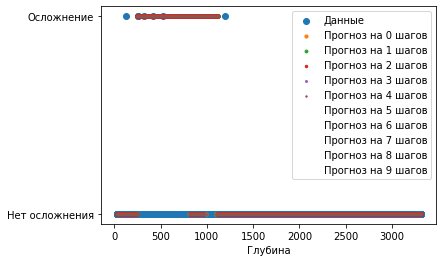

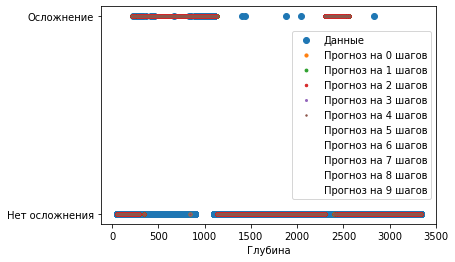

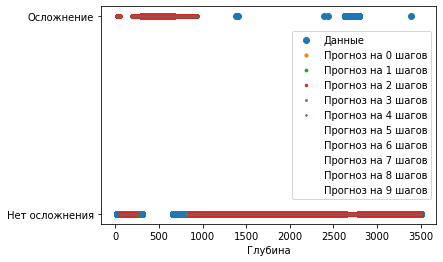

In [ ]:
for ind in random_samples_ind:
    X_well=total_X_grouped[ind]
    labels=total_Y_grouped[ind]
    outputs = best_model(torch.Tensor(X_well).to(device))
    arr=np.where(labels[:,0]==0, "Нет осложнения", "Осложнение")
    plt.scatter(X_well[:,-1,0]*max_depth,arr, label='Данные')
    for ind_out, output in enumerate(outputs):
      #label=labels[:,ind_out]
      _, predicted = torch.max(output.data, 1)
      pred = predicted.cpu()
      
      plt.scatter(X_well[:,-1,0]*max_depth,pred, s=10-2*ind_out, label=f'Прогноз на {ind_out} шагов')
      
    plt.xlabel('Глубина')
    #plt.ylabel('Error code')
      #N = len(labels[:,0][labels[:,0]>0])
      #N_err_pred=((pred.numpy() == Y_well) & (Y_well>0)).sum()
      #print(f"Number of errors: {N}")
      #print(f"Number of right errors prediction: {N_err_pred}")
      #print(f"Error prediction accuracy: {N_err_pred/N}")
      #plt.savefig()
    plt.legend()
    plt.show()

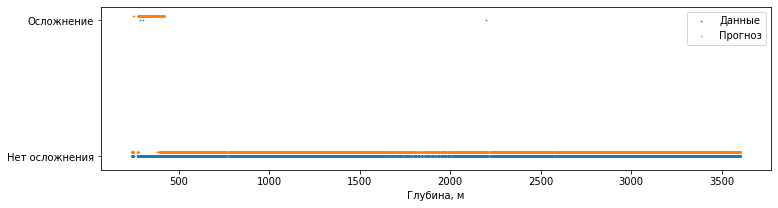

In [ ]:
plt.figure(figsize=(12,3))
plt.scatter(X_grouped[:,-1,0]*max_depth,arr, s=0.5, label='Данные')
plt.scatter(X_grouped[:,-1,0]*max_depth,predicted+0.03, s=0.5, label='Прогноз')
plt.legend()
plt.xlabel('Глубина, м')
plt.ylim(top=1.1, bottom=-0.1)
#plt.ylabel('Error code')
#plt.savefig(directory+'Data/8301_RNN.png',dpi=600, facecolor='white', bbox_inches='tight')
plt.show()

# Сохранение модели

In [ ]:
filename=f'Code/trained_models/{X_train.size()}samples_accuracy_{error_acc[0]:.5}_future_pred'
filename

'Code/trained_models/torch.Size([666350, 50, 41])samples_accuracy_0.77309_future_pred'

In [ ]:
torch.save(best_model, directory+filename+'.pth')

In [ ]:
cols=columns_to_use+["Код Литологии", "Код стратиграфии", "Код осложнений"]
with open(directory+filename+'_Order_of_columns.csv', 'w') as f:
    for column in cols:
        f.write(column +'\n')